# LR-FOSI: GoM change associated with decadal coastal SSH signal

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import dask
import copy
import matplotlib.pyplot as plt
#from geocat.viz import util as gvutil
import util
import cartopy.crs as ccrs
import xesmf as xe
import os
%matplotlib inline

from mypyutils import calendar_utils as cal
from mypyutils import stat_utils as stat
from mypyutils import mapplot_utils as maps
from mypyutils import colorbar_utils as cbars
from mypyutils import io_utils as io
from mypyutils import regrid_utils as regrid

In [2]:
import dask
from dask.distributed import wait
dask.__version__

'2023.7.0'

## Create Dask Cluster

In [85]:
# Close out Dask Cluster and release workers:
# NOTE:  only run this cell to terminate Dask Cluster!
client.shutdown()

In [3]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='10GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=10GB',
        account='NCGD0011',
        walltime='02:00:00',
        local_directory='/glade/scratch/yeager/',
        log_directory='/glade/scratch/yeager/',
        interface='ext',
        job_script_prologue=[
        f'export ESMFMKFILE={os.environ["ESMFMKFILE"]}'])

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status',
        "distributed.scheduler.worker-saturation": "1.0",
        'array.slicing.split_large_chunks': True
    })
    client = Client(cluster)
    return cluster, client

In [4]:
cluster, client = get_ClusterClient()
cluster.scale(30) 

In [5]:
client

<Client: 'tcp://128.117.208.108:35947' processes=0 threads=0, memory=0 B>

# Main Processing

In [7]:
# Get monthly SSH
def preprocessor(d0):
    d0 = d0[['SSH']]
    d0 = cal.time_set_midmonth(d0,'time')
    return d0

In [6]:
fdir = '/glade/campaign/cesm/development/espwg/SMYLE/initial_conditions/SMYLE-FOSI/ocn/proc/tseries/month_1/'
fin = fdir + 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.SMYLE.005.pop.h.SSH.030601-036812.nc'
ds_pop = xr.open_dataset(fin).isel(z_t=0)
ds_pop = cal.time_set_midmonth(ds_pop,'time')
nt = ds_pop.dims['time']
years = ds_pop.time.dt.year
mons = ds_pop.time.dt.month
ds_pop['time'] = [cftime.DatetimeNoLeap(years[i]+1652, mons[i], 15) for i in range(nt)]

In [8]:
import pop_tools
ds_g17 = pop_tools.get_grid('POP_gx1v7')
lr_lat = ds_g17.TLAT.fillna(0)
lr_lon = ds_g17.TLONG.fillna(0)
lr_kmt = ds_g17.KMT
lr_tarea = ds_g17.TAREA
lr_rmask = ds_g17.REGION_MASK

In [9]:
lr_lon = xr.where(lr_lon>180.,lr_lon-360,lr_lon)

In [16]:
ds_pop['TLONG'] = lr_lon
ds_pop['TLAT'] = lr_lat

### Correlation between inflow/outflow of GoM and interior SSH

In [10]:
# Use xoak to select specific [lat,lon] nearest values from CAM unstructured grid:
import xoak
def kdtree_sel_POPT(ds, lats, lons):
    if not ds.xoak.index:
        ds.xoak.set_index(("TLAT", "TLONG"), "scipy_kdtree")
    return ds.xoak.sel(TLAT=xr.Variable("ncol", lats1), TLONG=xr.Variable("ncol", lons1))

def kdtree_sel_POPU(ds, lats, lons):
    if not ds.xoak.index:
        ds.xoak.set_index(("ULAT", "ULONG"), "scipy_kdtree")
    return ds.xoak.sel(ULAT=xr.Variable("ncol", lats1), ULONG=xr.Variable("ncol", lons1))

In [17]:
%%time
sshann = ds_pop.SSH.drop(['ULAT','ULONG']).groupby('time.year').mean('time').rename({'year':'time'})

CPU times: user 2.35 s, sys: 67.7 ms, total: 2.42 s
Wall time: 2.61 s


In [18]:
annssh2015 = sshann.sel(time=2015)
annssh2005 = sshann.sel(time=2005)
annsshdiff = annssh2015 - annssh2005

In [19]:
%%time
lons1 = [-87,-84.6,-81,-81]
lats1 = [21.6,22,23.2,25.1]
ssh1 = kdtree_sel_POPT(annssh2005,lats1,lons1).load().squeeze()

CPU times: user 38.6 ms, sys: 3.87 ms, total: 42.4 ms
Wall time: 47.5 ms


In [20]:
ssh1

<xarray.DataArray 'SSH' (ncol: 4)>
array([ -6.7850165,  35.069187 ,  30.114534 , -11.424317 ], dtype=float32)
Coordinates:
    z_t      float32 500.0
    TLONG    (ncol) float64 -86.59 -84.33 -80.94 -80.91
    TLAT     (ncol) float64 21.63 22.04 23.35 25.22
    time     int64 2005
Dimensions without coordinates: ncol
Attributes:
    long_name:     Sea Surface Height
    units:         centimeter
    grid_loc:      2110
    cell_methods:  time: mean

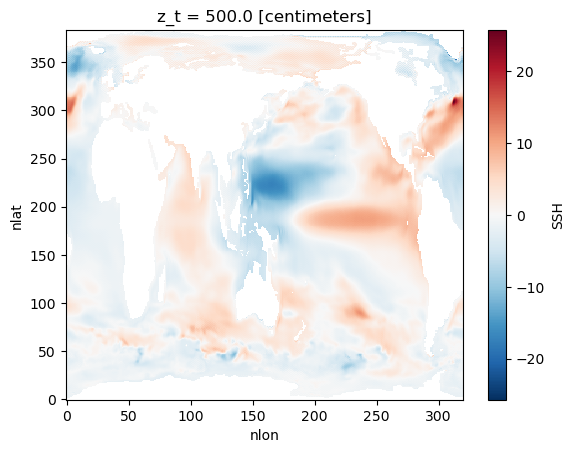

In [25]:
annsshdiff.plot()

In [29]:
lon, lat, dat = maps.adjust_pop_grid(lr_lon, lr_lat, annsshdiff)

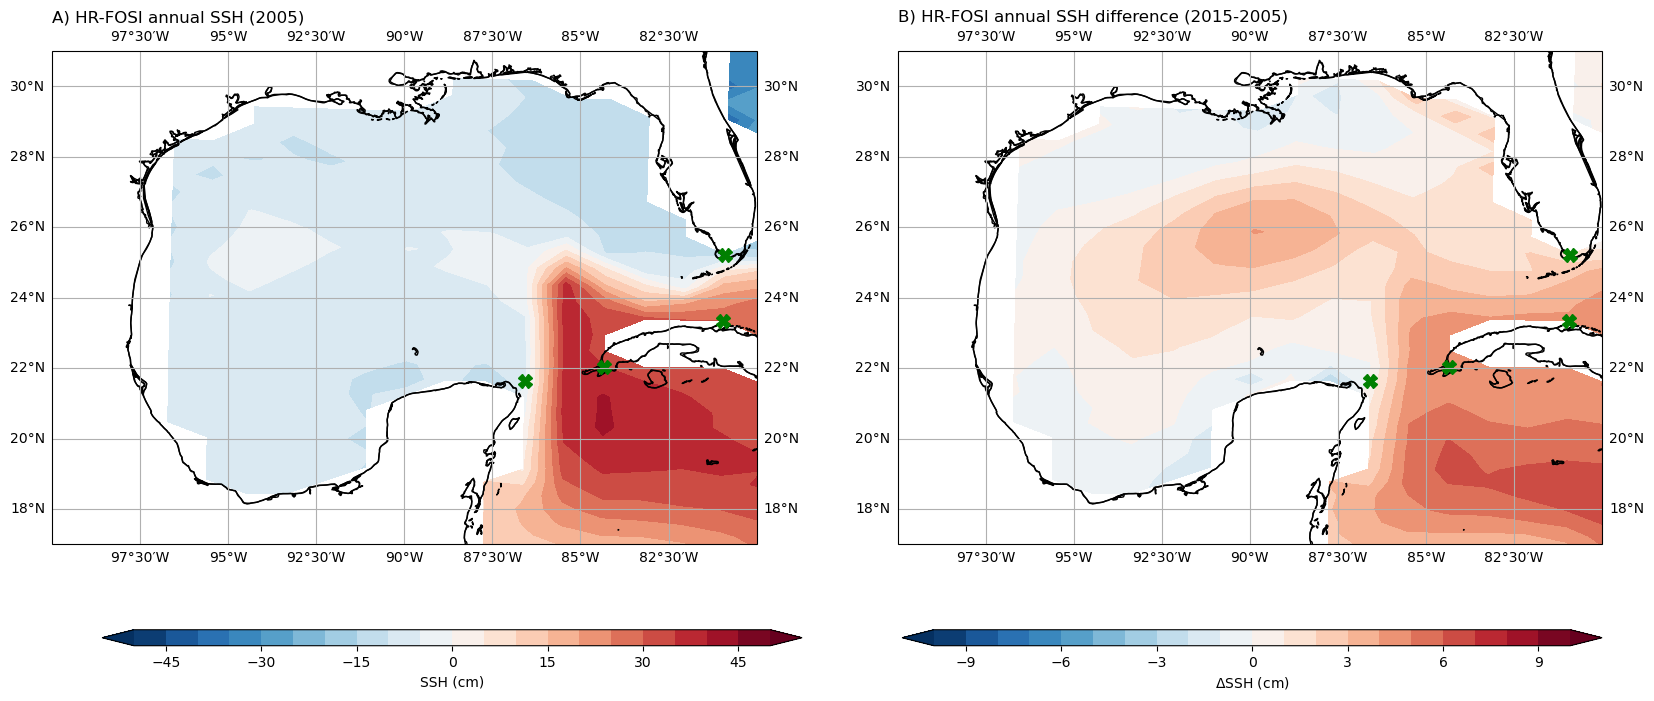

In [30]:
central_lon, central_lat = -90, 25
fontsize=12

sshlevs = np.arange(0,21,1)*5. - 50
sshdifflevs = np.arange(0,21,1)*1 - 10

colmap = copy.copy(plt.cm.RdBu_r)

# Create projection:
proj1 = ccrs.PlateCarree()
proj2 = ccrs.Orthographic(central_lon, central_lat)
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(1, 2, 1, projection=proj1)
ax2 = fig.add_subplot(1, 2, 2, projection=proj1)

rlevs = np.arange(0,21,1)*0.1 - 1

lon, lat, dat = maps.adjust_pop_grid(lr_lon, lr_lat, annssh2005)
cntr1 = ax1.contourf(lon, lat, dat, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax1.coastlines(resolution='50m')
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax1.set_title('A) HR-FOSI annual SSH (2005)',fontsize=fontsize, loc='left')
ax1.coastlines()
extent = [-100,-80, 17, 31]
ax1.set_extent(extent,crs=ccrs.PlateCarree())
ax1.plot(ssh1.TLONG, ssh1.TLAT,'X',markersize=10,c='g',transform=ccrs.PlateCarree())

lon, lat, dat = maps.adjust_pop_grid(lr_lon, lr_lat, annsshdiff)
cntr2 = ax2.contourf(lon, lat, dat, levels=sshdifflevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax2.coastlines(resolution='50m')
ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax2.set_title('B) HR-FOSI annual SSH difference (2015-2005)',fontsize=fontsize, loc='left')
ax2.coastlines()
extent = [-100,-80, 17, 31]
ax2.set_extent(extent,crs=ccrs.PlateCarree())
ax2.plot(ssh1.TLONG, ssh1.TLAT,'X',markersize=10,c='g',transform=ccrs.PlateCarree())

fig.subplots_adjust(bottom=0.15,right=0.9)
cbar_ax1 = fig.add_axes([0.15, 0.08, 0.35, 0.02])
fig.colorbar(cntr1, cax=cbar_ax1, orientation='horizontal',label='SSH (cm)')
cbar_ax2 = fig.add_axes([0.55, 0.08, 0.35, 0.02])
fig.colorbar(cntr2, cax=cbar_ax2, orientation='horizontal',label=r'$\Delta$SSH (cm)')

In [31]:
%%time
ssh1 = kdtree_sel_POPT(sshann,lats1,lons1).load().squeeze()

CPU times: user 45.1 ms, sys: 0 ns, total: 45.1 ms
Wall time: 47.6 ms


In [32]:
ssh1_anom = ssh1 - ssh1.mean('time')
ssh_delta1 = ssh1_anom.isel(ncol=1) - ssh1_anom.isel(ncol=0)
ssh_delta2 = ssh1_anom.isel(ncol=2) - ssh1_anom.isel(ncol=3)
ssh_delta = ssh_delta1 - ssh_delta2

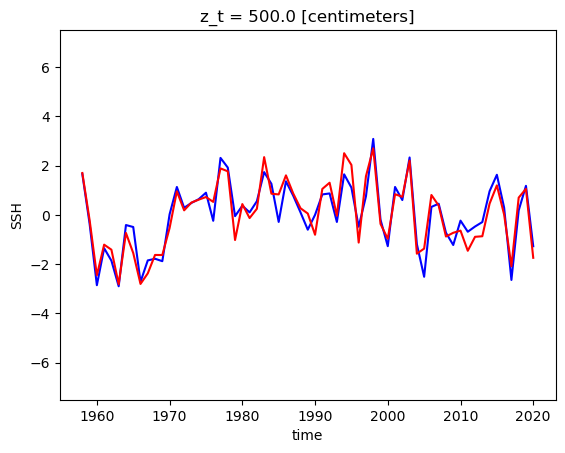

In [33]:
ssh_delta1.plot(c='b',ylim=[-7.5,7.5])
ssh_delta2.plot(c='r')

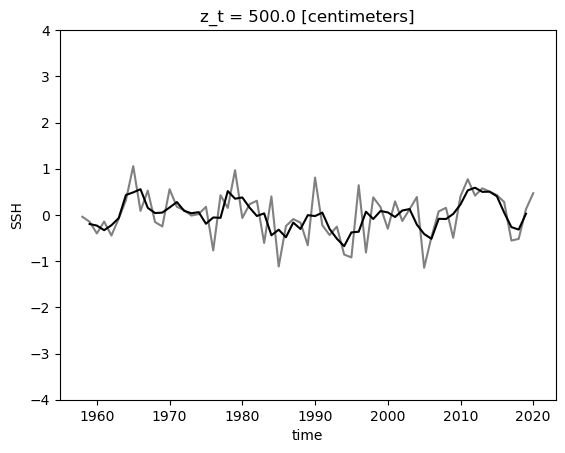

In [34]:
ssh_delta.plot(c='grey',ylim=[-4,4])
ssh_delta.rolling(time=3, center=True).mean().plot(c='k')

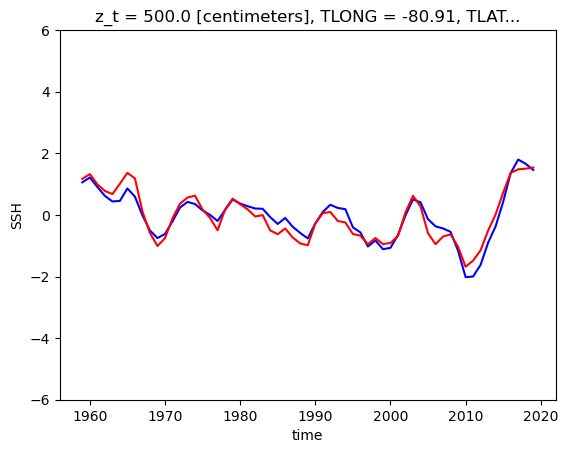

In [35]:
ssh1_anom.isel(ncol=0).rolling(time=3, center=True).mean().plot(c='b',ylim=[-6,6])
ssh1_anom.isel(ncol=3).rolling(time=3, center=True).mean().plot(c='r')

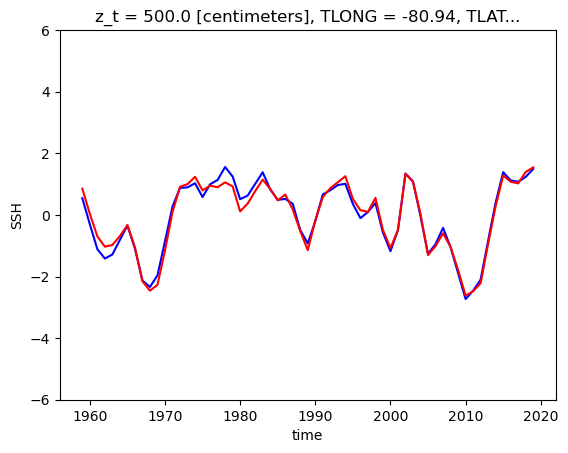

In [36]:
ssh1_anom.isel(ncol=1).rolling(time=3, center=True).mean().plot(c='b',ylim=[-6,6])
ssh1_anom.isel(ncol=2).rolling(time=3, center=True).mean().plot(c='r')

In [37]:
coastal_diff = ssh1_anom.isel(ncol=3).rolling(time=3, center=True).mean() - ssh1_anom.isel(ncol=0).rolling(time=3, center=True).mean()
interior_diff = ssh1_anom.isel(ncol=1).rolling(time=3, center=True).mean() - ssh1_anom.isel(ncol=2).rolling(time=3, center=True).mean()

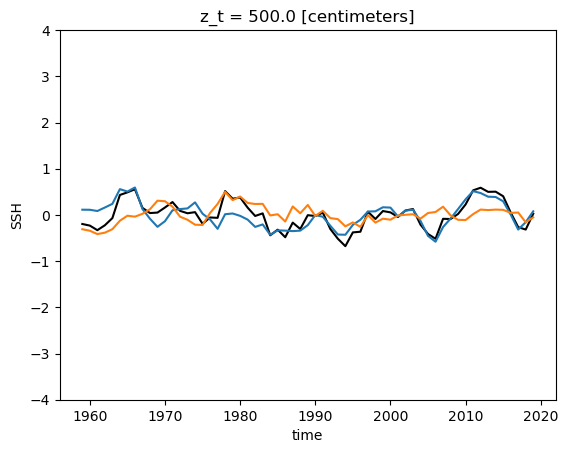

In [38]:
ssh_delta.rolling(time=3, center=True).mean().plot(c='k',ylim=[-4,4], label='inflow-outflow')
coastal_diff.plot()
interior_diff.plot()

In [39]:
def POP_regional_areawgt(da,tarea,lonlat):
    tlat = da.TLAT
    tlon = xr.where(da.TLONG>180.,da.TLONG-360.,da.TLONG)
    region = (tlat>=lonlat[2]) & (tlat<=lonlat[3]) & (tlon>=lonlat[0]) & (tlon<=lonlat[1])
    return xr.where(region,tarea.fillna(0),0)

In [40]:
reglonlat = [-99.,-81.,22.,30.]

In [41]:
POP_regarea = POP_regional_areawgt(ds_g17,lr_tarea,reglonlat).load()

In [42]:
%%time
lr_regssh = sshann.weighted(POP_regarea).mean(("nlon", "nlat")).load()

CPU times: user 45.4 ms, sys: 7.88 ms, total: 53.2 ms
Wall time: 56.6 ms


In [43]:
lr_regssh_anom = lr_regssh - lr_regssh.mean('time')

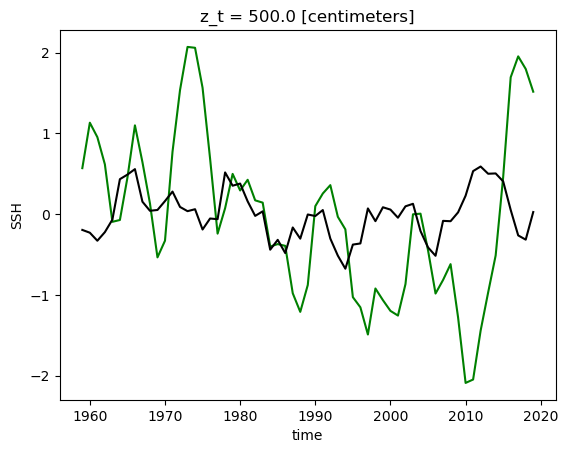

In [44]:
lr_regssh_anom.rolling(time=3, center=True).mean().plot(c='g')
#ssh_delta.plot(c='k')
ssh_delta.rolling(time=3, center=True).mean().plot(c='k')

## Interannual Variability: Acceleration of sea level rise in GoM and SEUS

#### Altimetry Data

In [45]:
datadir = '/glade/work/clittle/altimetry/MEASURES/monthly/'
alt=xr.open_mfdataset(datadir+'monthly_*.nc')
alt=alt*100        # convert to cm
alt=alt.rename({'Time': 'time'})
nt = alt.dims['time']
years = alt.time.dt.year
mons = alt.time.dt.month
alt['time'] = [cftime.DatetimeNoLeap(years[i], mons[i], 15) for i in range(nt)]
altmon = alt.SLA

In [46]:
alt_montime = altmon.time.dt.year + (altmon.time.dt.month-0.5)/12.

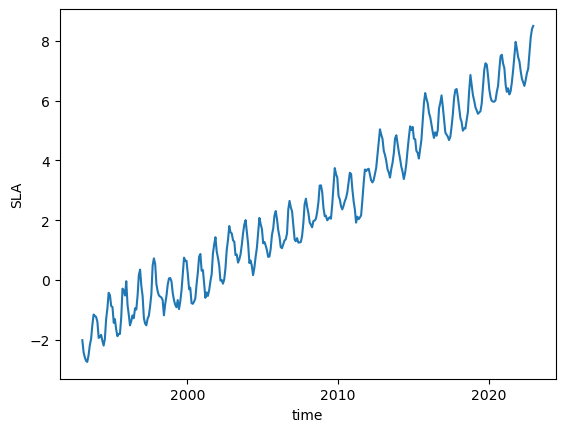

In [47]:
# remove global mean signal for comparison with FOSI
weights = np.cos(np.deg2rad(altmon.Latitude))
altmon_global = altmon.weighted(weights).mean('Latitude').mean('Longitude')
altmon_global.plot()

In [48]:
altmon_raw = altmon

In [49]:
altmon = altmon - altmon_global

In [50]:
altann = altmon.groupby('time.year').mean('time').rename({'year':'time'}).load()

In [47]:
altann_raw = altmon_raw.groupby('time.year').mean('time').rename({'year':'time'})

### 1993-2018 Std. Dev.

In [51]:
alt_sd = altann.std('time').load()

In [52]:
lr_ssh_sd = sshann.sel(time=slice(1993,2018)).std('time').load()

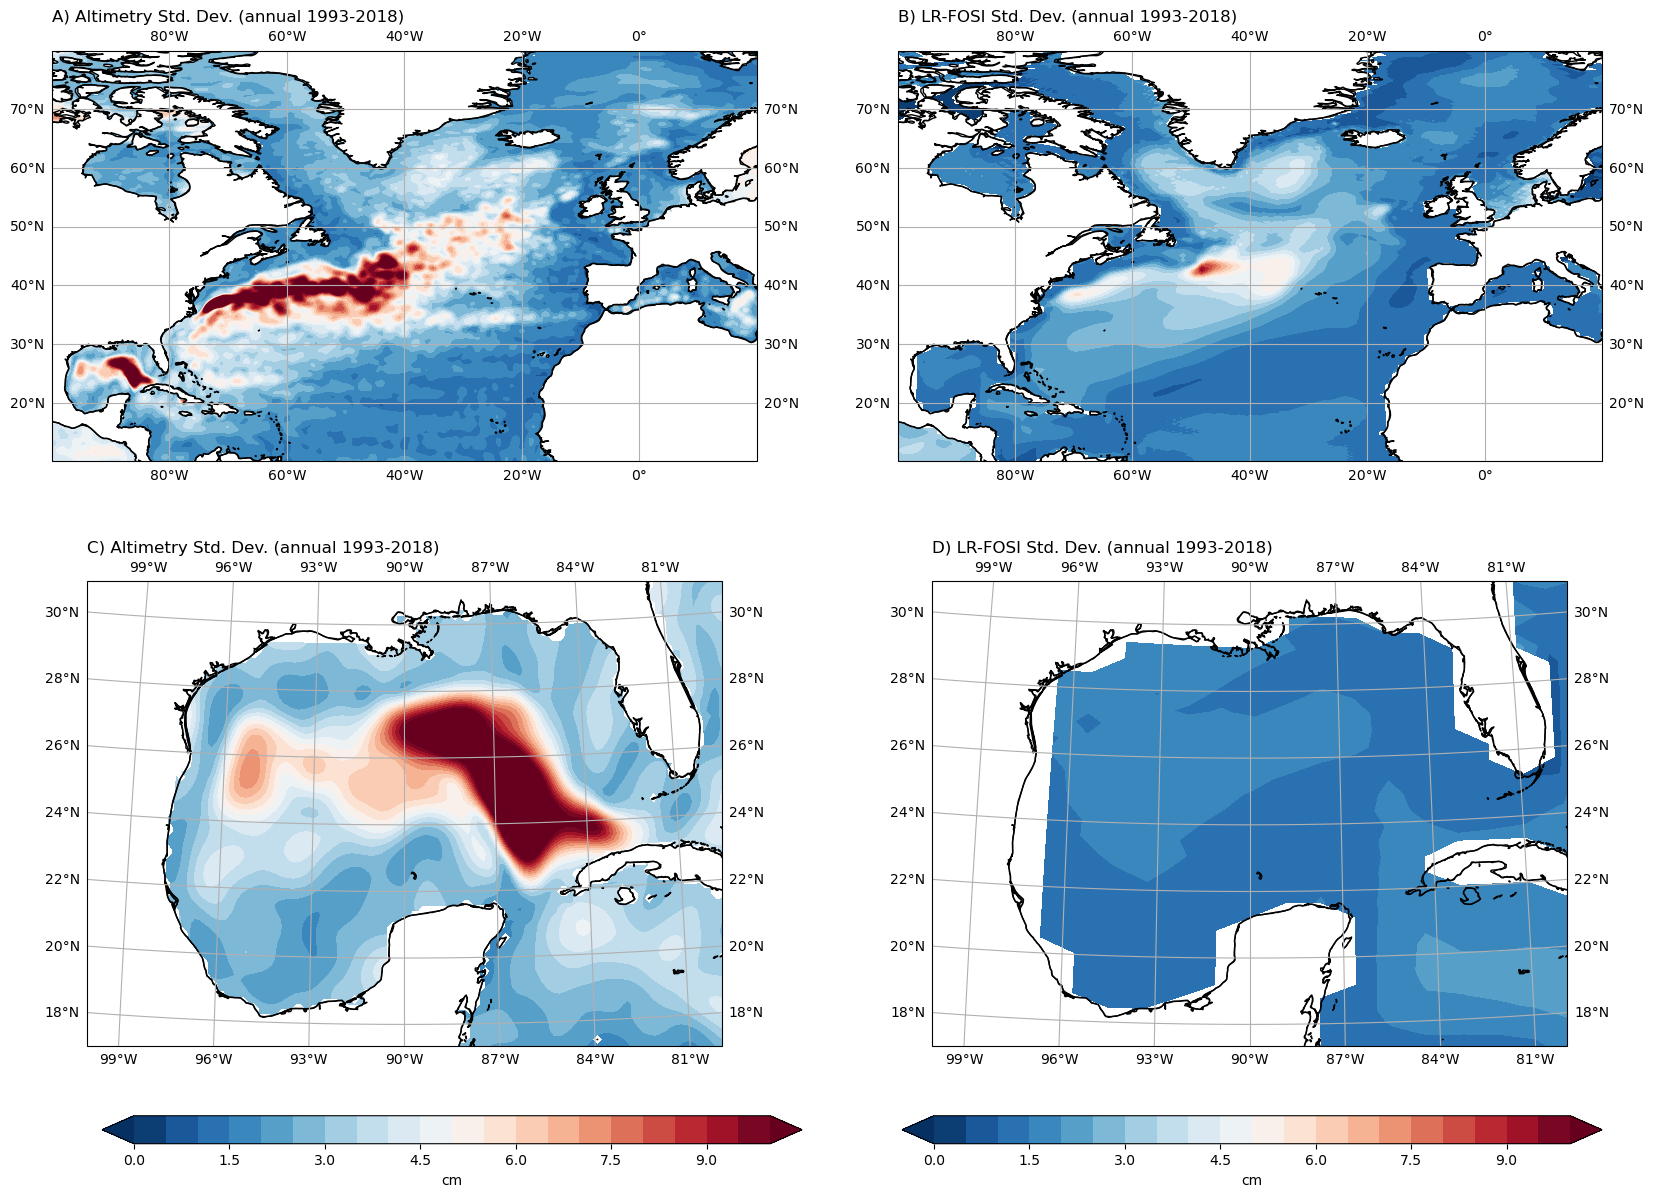

In [53]:
central_lon, central_lat = -90, 25
fontsize=12

colmap = copy.copy(plt.cm.RdBu_r)

# Create projection:
proj1 = ccrs.PlateCarree()
proj2 = ccrs.Orthographic(central_lon, central_lat)
fig = plt.figure(figsize=(20, 14))
ax1 = fig.add_subplot(2, 2, 1, projection=proj1)
ax2 = fig.add_subplot(2, 2, 2, projection=proj1)
ax3 = fig.add_subplot(2, 2, 3, projection=proj2)
ax4 = fig.add_subplot(2, 2, 4, projection=proj2)

sshlevs = np.arange(0,21,1)*0.5 

cntr1 = ax1.contourf(alt_sd.Longitude, alt_sd.Latitude, alt_sd, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax1.coastlines(resolution='50m')
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax1.set_title('A) Altimetry Std. Dev. (annual 1993-2018)',fontsize=fontsize, loc='left')
ax1.coastlines()
extent = [-100,20, 10, 80]
ax1.set_extent(extent,crs=ccrs.PlateCarree())

lon, lat, dat = maps.adjust_pop_grid(lr_lon, lr_lat, lr_ssh_sd)
cntr2 = ax2.contourf(lon, lat, dat, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax2.coastlines(resolution='50m')
ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax2.set_title('B) LR-FOSI Std. Dev. (annual 1993-2018)',fontsize=fontsize, loc='left')
ax2.coastlines()
extent = [-100,20, 10, 80]
ax2.set_extent(extent,crs=ccrs.PlateCarree())

cntr3 = ax3.contourf(alt_sd.Longitude, alt_sd.Latitude, alt_sd, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax3.coastlines(resolution='50m')
ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax3.set_title('C) Altimetry Std. Dev. (annual 1993-2018)',fontsize=fontsize, loc='left')
ax3.coastlines()
extent = [-100,-80, 17, 31]
ax3.set_extent(extent,crs=ccrs.PlateCarree())

cntr4 = ax4.contourf(lon, lat, dat, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax4.coastlines(resolution='50m')
ax4.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax4.set_title('D) LR-FOSI Std. Dev. (annual 1993-2018)',fontsize=fontsize, loc='left')
ax4.coastlines()
extent = [-100,-80, 17, 31]
ax4.set_extent(extent,crs=ccrs.PlateCarree())

fig.subplots_adjust(bottom=0.15,right=0.9)
cbar_ax1 = fig.add_axes([0.15, 0.08, 0.35, 0.02])
fig.colorbar(cntr1, cax=cbar_ax1, orientation='horizontal',label='cm')
cbar_ax2 = fig.add_axes([0.55, 0.08, 0.35, 0.02])
fig.colorbar(cntr2, cax=cbar_ax2, orientation='horizontal',label='cm')

Interannual Std. Dev. (1993-2018) of DSL from altimetry (left) and LR-FOSI (right).

### 2000-2015 Trend

In [54]:
import xskillscore as xs

In [55]:
%%time
tmp = altann.sel(time=slice(2000,2015))
alt_trend = xs.linslope(tmp.time,tmp,dim='time')

CPU times: user 316 ms, sys: 235 ms, total: 551 ms
Wall time: 599 ms


In [56]:
%%time
tmp = sshann.sel(time=slice(2000,2015))
lr_trend = xs.linslope(tmp.time,tmp,dim='time').load()

CPU times: user 23.6 ms, sys: 9 µs, total: 23.6 ms
Wall time: 24.3 ms


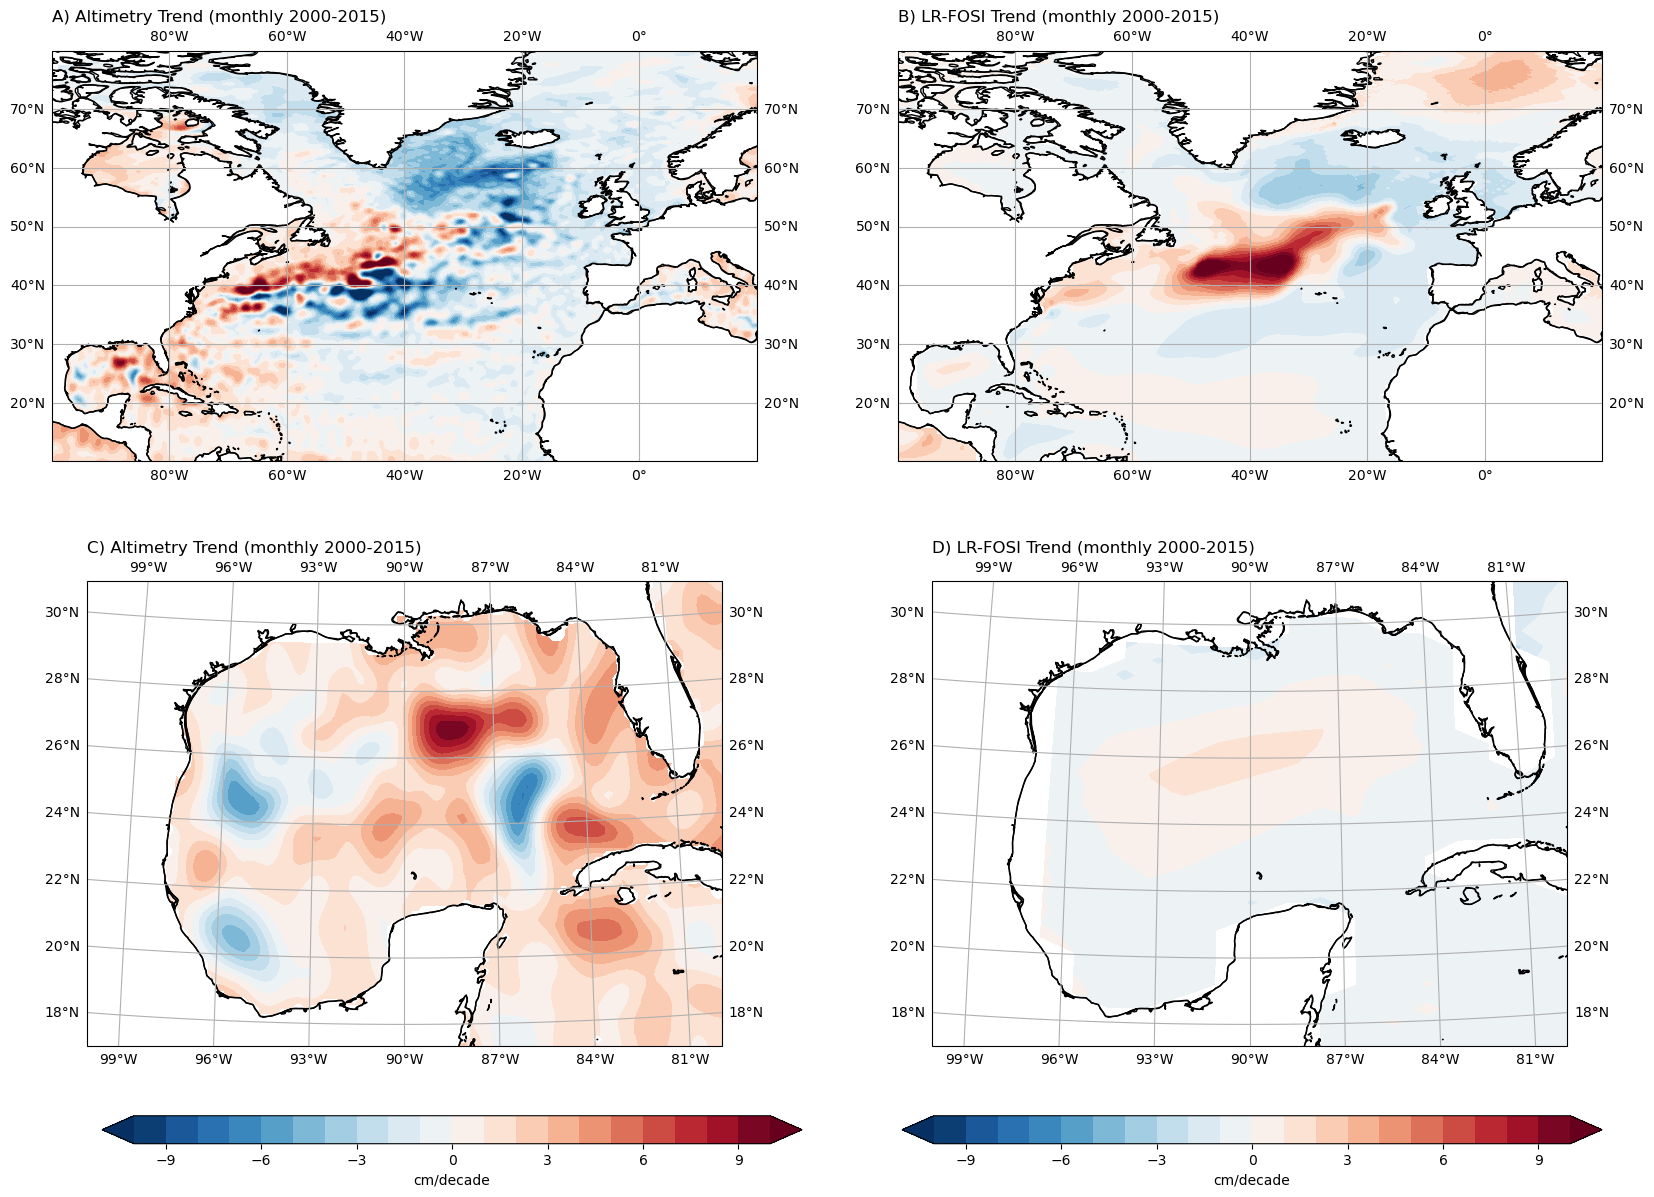

In [57]:
central_lon, central_lat = -90, 25
fontsize=12

colmap = copy.copy(plt.cm.RdBu_r)

# Create projection:
proj1 = ccrs.PlateCarree()
proj2 = ccrs.Orthographic(central_lon, central_lat)
fig = plt.figure(figsize=(20, 14))
ax1 = fig.add_subplot(2, 2, 1, projection=proj1)
ax2 = fig.add_subplot(2, 2, 2, projection=proj1)
ax3 = fig.add_subplot(2, 2, 3, projection=proj2)
ax4 = fig.add_subplot(2, 2, 4, projection=proj2)

sshlevs = np.arange(0,21,1)*1 - 10

cntr1 = ax1.contourf(alt_trend.Longitude, alt_trend.Latitude, alt_trend*10, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax1.coastlines(resolution='50m')
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax1.set_title('A) Altimetry Trend (monthly 2000-2015)',fontsize=fontsize, loc='left')
ax1.coastlines()
extent = [-100,20, 10, 80]
ax1.set_extent(extent,crs=ccrs.PlateCarree())

lon, lat, dat = maps.adjust_pop_grid(lr_lon, lr_lat, lr_trend)
cntr2 = ax2.contourf(lon, lat, dat*10, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax2.coastlines(resolution='50m')
ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax2.set_title('B) LR-FOSI Trend (monthly 2000-2015)',fontsize=fontsize, loc='left')
ax2.coastlines()
extent = [-100,20, 10, 80]
ax2.set_extent(extent,crs=ccrs.PlateCarree())

cntr3 = ax3.contourf(alt_trend.Longitude, alt_trend.Latitude, alt_trend*10, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax3.coastlines(resolution='50m')
ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax3.set_title('C) Altimetry Trend (monthly 2000-2015)',fontsize=fontsize, loc='left')
ax3.coastlines()
extent = [-100,-80, 17, 31]
ax3.set_extent(extent,crs=ccrs.PlateCarree())

cntr4 = ax4.contourf(lon, lat, dat*10, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax4.coastlines(resolution='50m')
ax4.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax4.set_title('D) LR-FOSI Trend (monthly 2000-2015)',fontsize=fontsize, loc='left')
ax4.coastlines()
extent = [-100,-80, 17, 31]
ax4.set_extent(extent,crs=ccrs.PlateCarree())

fig.subplots_adjust(bottom=0.15,right=0.9)
cbar_ax1 = fig.add_axes([0.15, 0.08, 0.35, 0.02])
fig.colorbar(cntr1, cax=cbar_ax1, orientation='horizontal',label='cm/decade')
cbar_ax2 = fig.add_axes([0.55, 0.08, 0.35, 0.02])
fig.colorbar(cntr2, cax=cbar_ax2, orientation='horizontal',label='cm/decade')

Linear trend (2000-2015) of DSL from altimetry (left) and LR-FOSI (right).

#### How much does trend contribute to 1993-2018 variability?

In [58]:
def trend_linear(da, dim):
    """ linear detrend DataArray along the axis dim """
    params = da.polyfit(dim=dim, deg=1)
    fit = xr.polyval(da[dim], params.polyfit_coefficients)
    return fit

In [59]:
%%time
altann_trend_sd = trend_linear(altann,'time').std('time').load()
alt_sd_ratio = altann_trend_sd/alt_sd

CPU times: user 7.56 s, sys: 331 ms, total: 7.89 s
Wall time: 8.51 s


In [61]:
%%time
lr_ssh_trend_sd = trend_linear(sshann.sel(time=slice(1993,2018)),'time').std('time').load()

CPU times: user 357 ms, sys: 4.25 ms, total: 361 ms
Wall time: 395 ms


In [62]:
lr_sd_ratio = lr_ssh_trend_sd/lr_ssh_sd

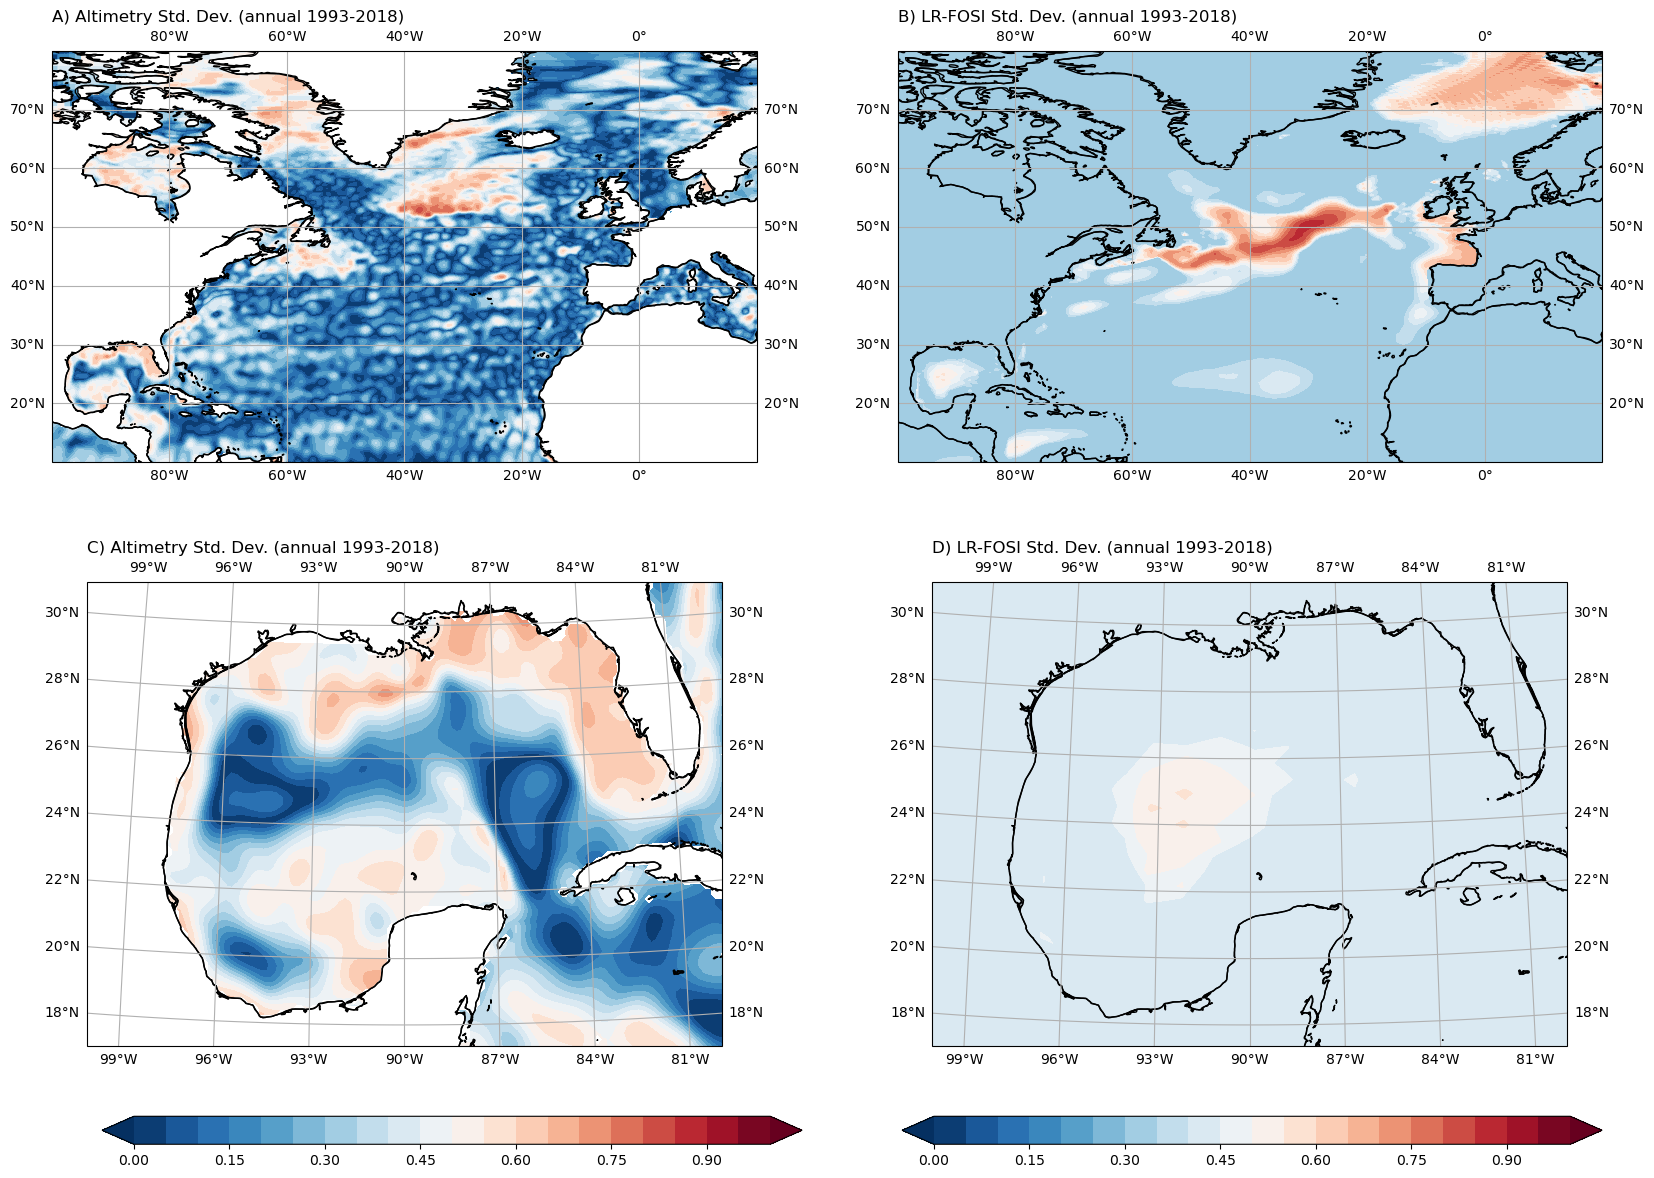

In [63]:
central_lon, central_lat = -90, 25
fontsize=12

colmap = copy.copy(plt.cm.RdBu_r)

# Create projection:
proj1 = ccrs.PlateCarree()
proj2 = ccrs.Orthographic(central_lon, central_lat)
fig = plt.figure(figsize=(20, 14))
ax1 = fig.add_subplot(2, 2, 1, projection=proj1)
ax2 = fig.add_subplot(2, 2, 2, projection=proj1)
ax3 = fig.add_subplot(2, 2, 3, projection=proj2)
ax4 = fig.add_subplot(2, 2, 4, projection=proj2)

sshlevs = np.arange(0,21,1)*0.05

cntr1 = ax1.contourf(alt_sd_ratio.Longitude, alt_sd_ratio.Latitude, alt_sd_ratio, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax1.coastlines(resolution='50m')
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax1.set_title('A) Altimetry Std. Dev. (annual 1993-2018)',fontsize=fontsize, loc='left')
ax1.coastlines()
extent = [-100,20, 10, 80]
ax1.set_extent(extent,crs=ccrs.PlateCarree())

lon, lat, dat = maps.adjust_pop_grid(lr_lon, lr_lat, lr_sd_ratio)
cntr2 = ax2.contourf(lon, lat, dat, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax2.coastlines(resolution='50m')
ax2.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax2.set_title('B) LR-FOSI Std. Dev. (annual 1993-2018)',fontsize=fontsize, loc='left')
ax2.coastlines()
extent = [-100,20, 10, 80]
ax2.set_extent(extent,crs=ccrs.PlateCarree())

cntr3 = ax3.contourf(alt_sd_ratio.Longitude, alt_sd_ratio.Latitude, alt_sd_ratio, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax3.coastlines(resolution='50m')
ax3.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax3.set_title('C) Altimetry Std. Dev. (annual 1993-2018)',fontsize=fontsize, loc='left')
ax3.coastlines()
extent = [-100,-80, 17, 31]
ax3.set_extent(extent,crs=ccrs.PlateCarree())

cntr4 = ax4.contourf(lon, lat, dat, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax4.coastlines(resolution='50m')
ax4.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax4.set_title('D) LR-FOSI Std. Dev. (annual 1993-2018)',fontsize=fontsize, loc='left')
ax4.coastlines()
extent = [-100,-80, 17, 31]
ax4.set_extent(extent,crs=ccrs.PlateCarree())

fig.subplots_adjust(bottom=0.15,right=0.9)
cbar_ax1 = fig.add_axes([0.15, 0.08, 0.35, 0.02])
fig.colorbar(cntr1, cax=cbar_ax1, orientation='horizontal',label='')
cbar_ax2 = fig.add_axes([0.55, 0.08, 0.35, 0.02])
fig.colorbar(cntr2, cax=cbar_ax2, orientation='horizontal',label='')

Fraction of interannual variability (1993-2018) explained by linear trend.

### Eastern GoM Variability

In [67]:
reglonlat = [-84.,-81.,25.,28.]

In [68]:
def add_box(ax,lonlat):
    x0 = lonlat[0]; x1 = lonlat[1]; y0 = lonlat[2]; y1 = lonlat[3]
    if ((x0>0) and (x1<0)):
        ax.plot(np.linspace(x0,x0,20), np.linspace(y0,y1,20), color='k',transform=ccrs.PlateCarree())
        ax.plot(np.linspace(x1,x1,20), np.linspace(y0,y1,20), color='k',transform=ccrs.PlateCarree())
        ax.plot(np.linspace(x0,180,20), np.linspace(y0,y0,20), color='k',transform=ccrs.PlateCarree())
        ax.plot(np.linspace(-180,x1,20), np.linspace(y0,y0,20), color='k',transform=ccrs.PlateCarree())
        ax.plot(np.linspace(x0,180,20), np.linspace(y1,y1,20), color='k',transform=ccrs.PlateCarree())
        ax.plot(np.linspace(-180,x1,20), np.linspace(y1,y1,20), color='k',transform=ccrs.PlateCarree())
    else:
        ax.plot(np.linspace(x0,x0,20), np.linspace(y0,y1,20), color='k',transform=ccrs.PlateCarree())
        ax.plot(np.linspace(x1,x1,20), np.linspace(y0,y1,20), color='k',transform=ccrs.PlateCarree())
        ax.plot(np.linspace(x0,x1,20), np.linspace(y0,y0,20), color='k',transform=ccrs.PlateCarree())
        ax.plot(np.linspace(x0,x1,20), np.linspace(y1,y1,20), color='k',transform=ccrs.PlateCarree())

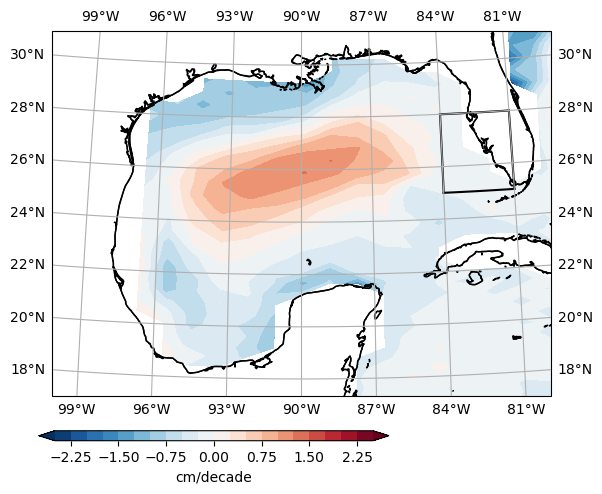

In [70]:
central_lon, central_lat = -90, 25
fontsize=12

colmap = copy.copy(plt.cm.RdBu_r)

# Create projection:
proj1 = ccrs.PlateCarree()
proj2 = ccrs.Orthographic(central_lon, central_lat)
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(1, 1, 1, projection=proj2)


sshlevs = np.arange(0,21,1)*0.25 - 2.5

lon, lat, dat = maps.adjust_pop_grid(lr_lon, lr_lat, lr_trend)
cntr1 = ax1.contourf(lon, lat, dat*10, levels=sshlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='both')
ax1.coastlines(resolution='50m')
ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax1.set_title('',fontsize=fontsize, loc='left')
ax1.coastlines()
extent = [-100,-80, 17, 31]
ax1.set_extent(extent,crs=ccrs.PlateCarree())
add_box(ax1,reglonlat)


fig.subplots_adjust(bottom=0.15,right=0.9)
cbar_ax1 = fig.add_axes([0.25, 0.06, 0.35, 0.02])
fig.colorbar(cntr1, cax=cbar_ax1, orientation='horizontal',label='cm/decade')

In [71]:
def POP_regional_areawgt(da,tarea,lonlat):
    tlat = da.TLAT
    tlon = xr.where(da.TLONG>180.,da.TLONG-360.,da.TLONG)
    region = (tlat>=lonlat[2]) & (tlat<=lonlat[3]) & (tlon>=lonlat[0]) & (tlon<=lonlat[1])
    return xr.where(region,tarea.fillna(0),0)

In [72]:
POP_regarea = POP_regional_areawgt(sshann,lr_tarea,reglonlat).load()

In [73]:
%%time
lr_regssh = sshann.weighted(POP_regarea).mean(("nlon", "nlat")).load()

CPU times: user 32 ms, sys: 11.9 ms, total: 43.8 ms
Wall time: 45 ms


In [74]:
tmp = lr_regssh.sel(time=slice(1993,2018)).mean('time')
lr_regssh = lr_regssh -tmp

In [75]:
altann_reg = altann.sel(Latitude=slice(reglonlat[2],reglonlat[3])).sel(Longitude=slice(reglonlat[0]+360,reglonlat[1]+360))

In [76]:
weights = np.cos(np.deg2rad(altann_reg.Latitude))
alt_regssh = altann_reg.weighted(weights).mean('Latitude').mean('Longitude')
alt_regssh = alt_regssh - alt_regssh.mean('time')

In [77]:
tmp = lr_regssh_anom - lr_regssh_anom.sel(time=slice(1993,2018)).mean('time')

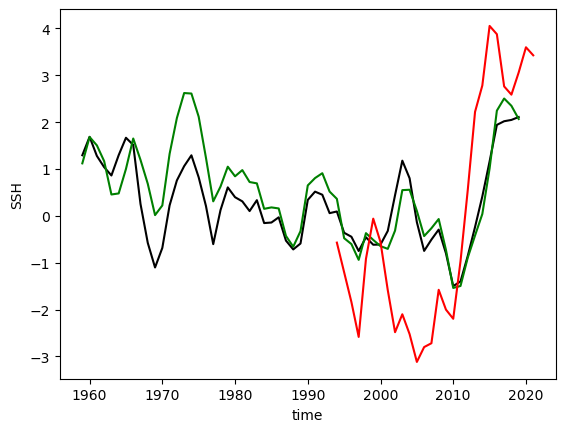

In [78]:
lr_regssh.rolling(time=3, center=True).mean().plot(c='k')
tmp.rolling(time=3, center=True).mean().plot(c='g')
alt_regssh.rename('SSH').rolling(time=3, center=True).mean().plot(c='r')

In [79]:
def lag_regress(x, y, lagx=0, lagy=0):
    x,y = xr.align(x,y)
    if lagx!=0:
        if lagx>0: x = x.shift(time = -lagx).isel(time=slice(0,-lagx))
        if lagx<0: x = x.shift(time = -lagx).isel(time=slice(-lagx,None))
    if lagy!=0:
        if lagy>0: y = y.shift(time = -lagy).isel(time=slice(0,-lagy))
        if lagy<0: y = y.shift(time = -lagy).isel(time=slice(-lagy,None))       
    x,y = xr.align(x,y)
    corr = xs.pearson_r(x,y,dim='time',skipna=True)
    slope = xs.linslope(x,y,dim='time',skipna=True)
    neff = xs.effective_sample_size(x,y,dim='time',skipna=True)
    pval = xs.pearson_r_eff_p_value(x,y,dim='time')
    stats = xr.DataArray(['corr','slope','pval','neff'],dims="stat",name="stat")
    xrout = xr.concat([corr,slope,pval,neff],dim=stats)
    return xrout

def concat_regress(x, y, lagyrange):
    """ y is a field being regressed onto x, with y lagging by lagyrange 
    """
    results = []
    lag = xr.DataArray([i for i in lagyrange],dims='lag',name='lag')
    for i in lagyrange:
        result = lag_regress(x,y,lagy=i)
        results.append(result)
    return xr.concat(results,dim=lag)

In [80]:
lagrange = range(-10,3,1)
lag = xr.DataArray([i for i in lagrange],dims='lag',name='lag')
lag

<xarray.DataArray 'lag' (lag: 13)>
array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2])
Dimensions without coordinates: lag

In [81]:
ydat = sshann.load()

In [82]:
%%time
xdat = lr_regssh.rolling(time=3, center=True).mean()
#ydat = sshann.chunk(dict(time=-1))
# Note xdat leads/lags for positive/negative lags
ssh_reg_egom = concat_regress(xdat,ydat,lagrange)

/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/xs

CPU times: user 15.4 s, sys: 5.53 s, total: 21 s
Wall time: 21.9 s


/glade/work/yeager/conda-envs/mypythonenv/lib/python3.10/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


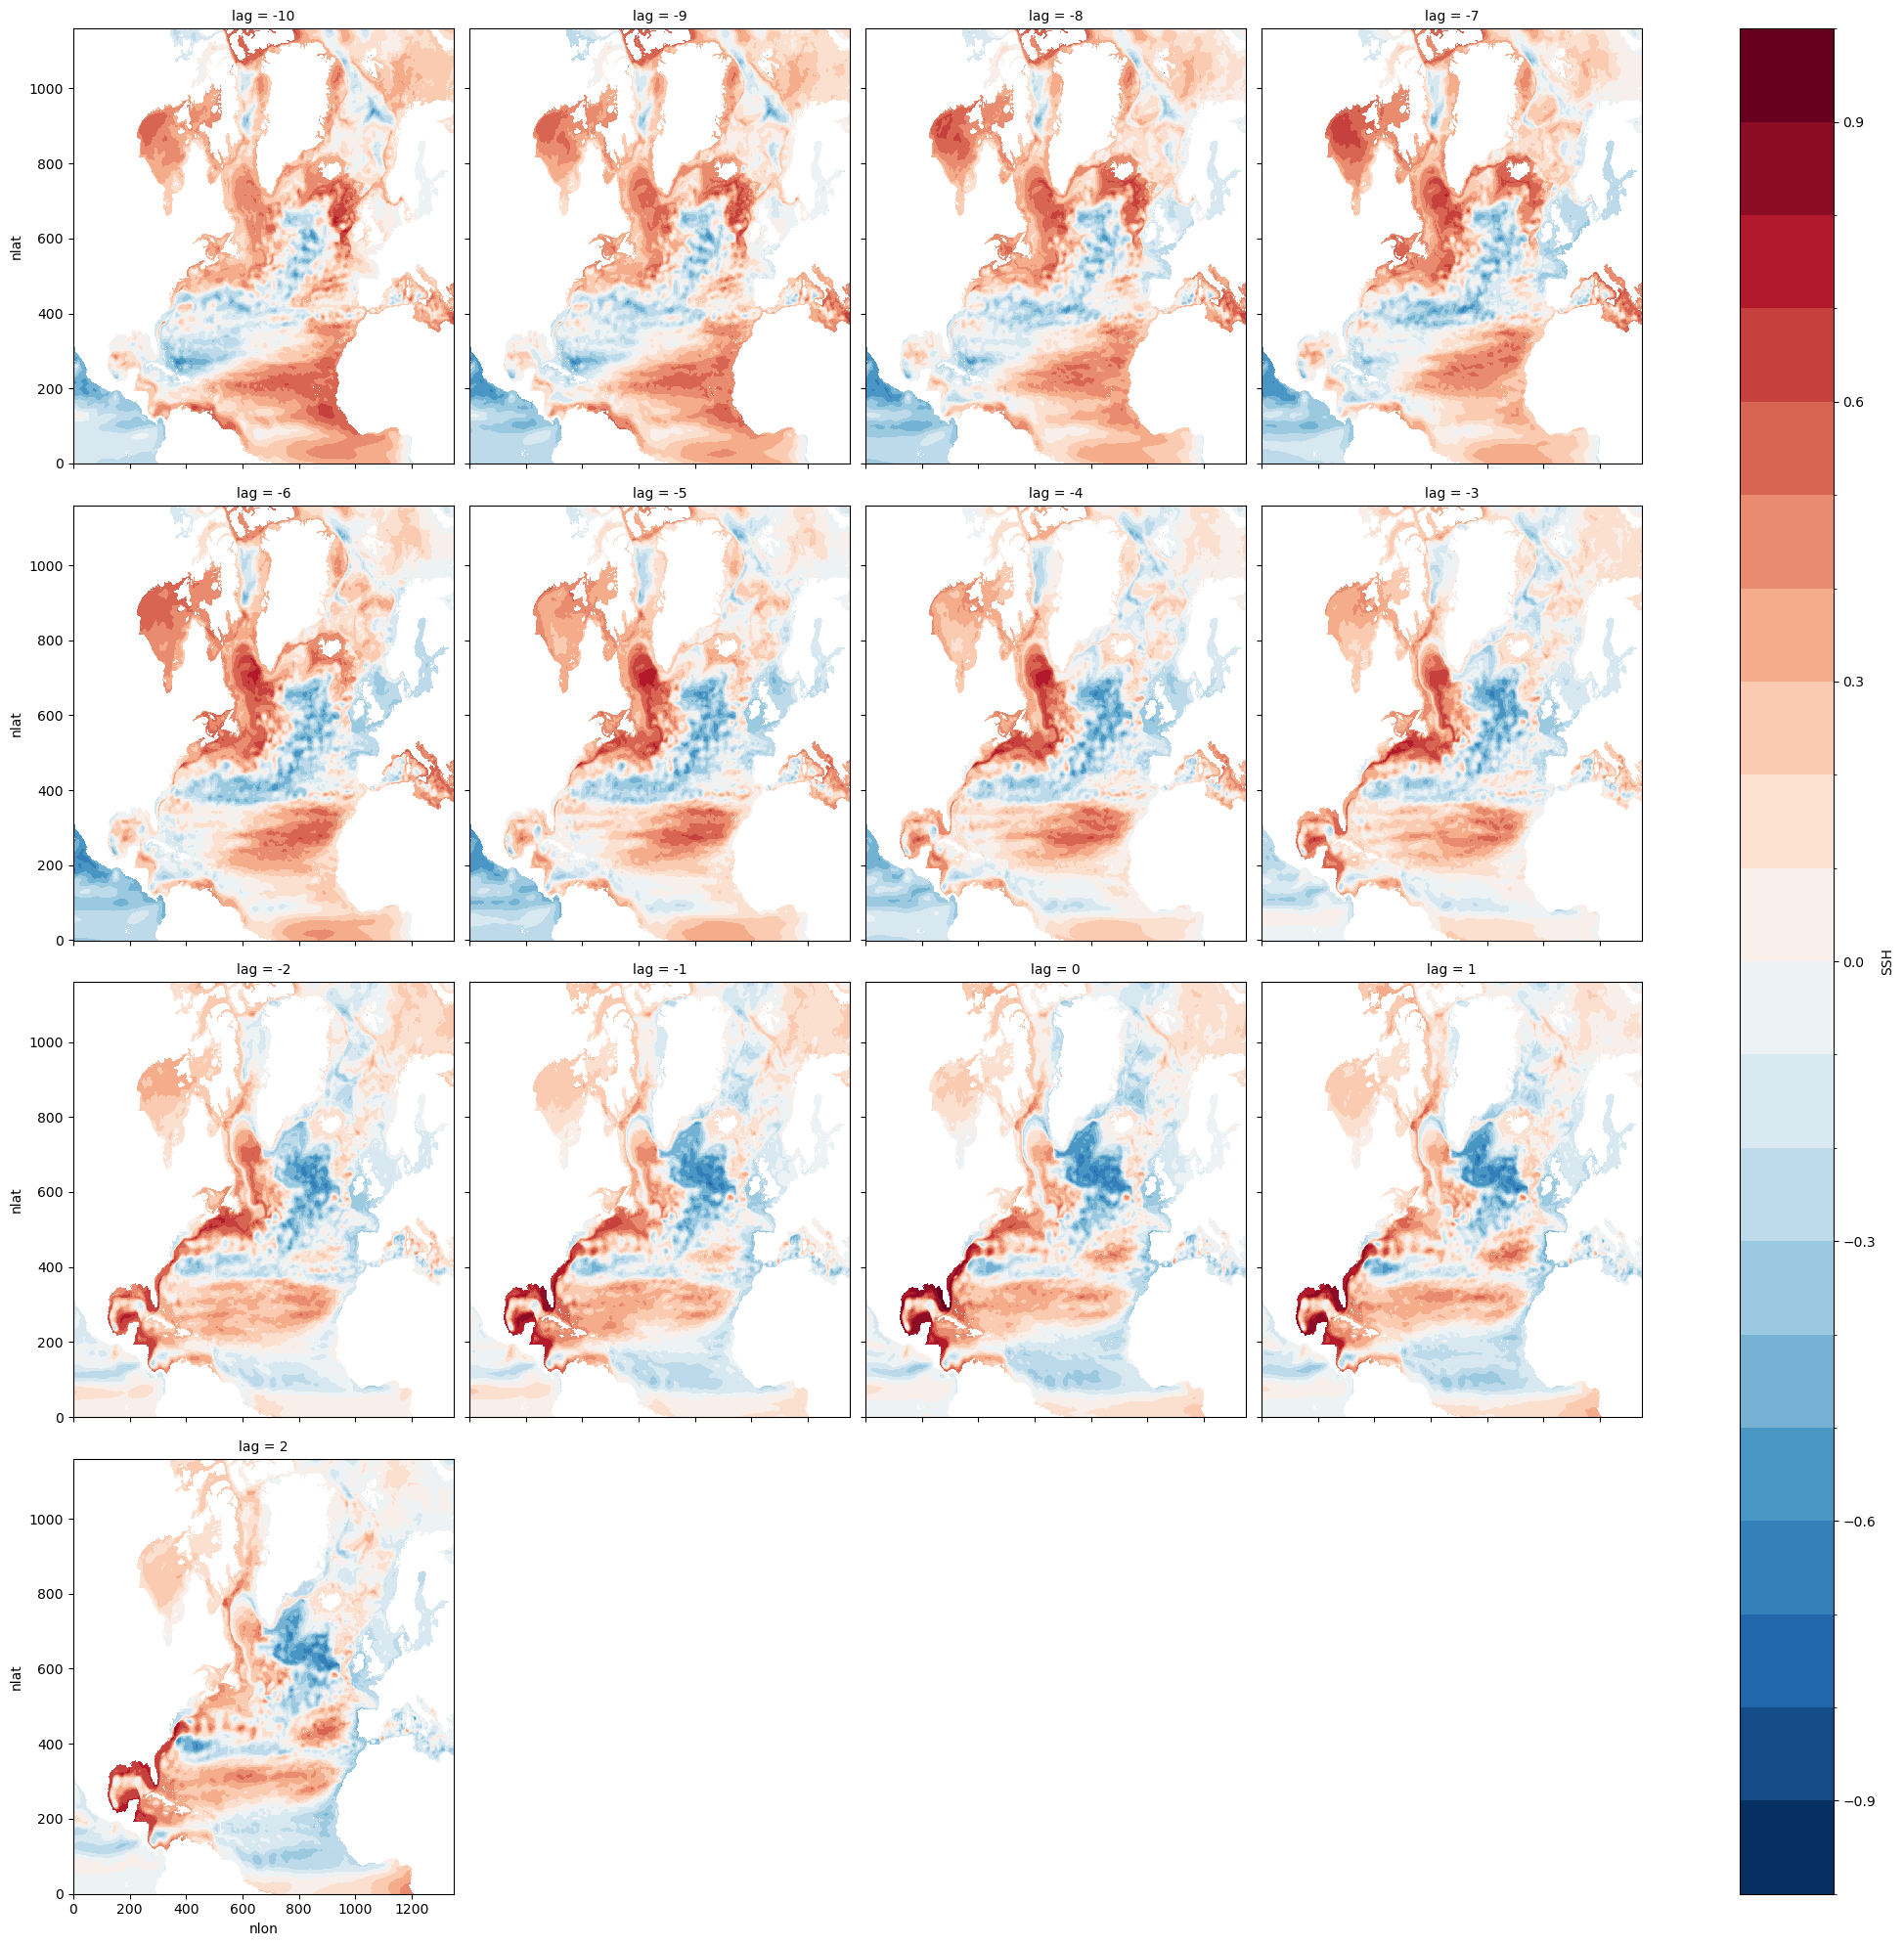

In [38]:
levs = np.arange(0,21)*0.1-1
ssh_reg_egom.sel(stat='corr').plot.imshow(col='lag',size=5,levels=levs,col_wrap=4)

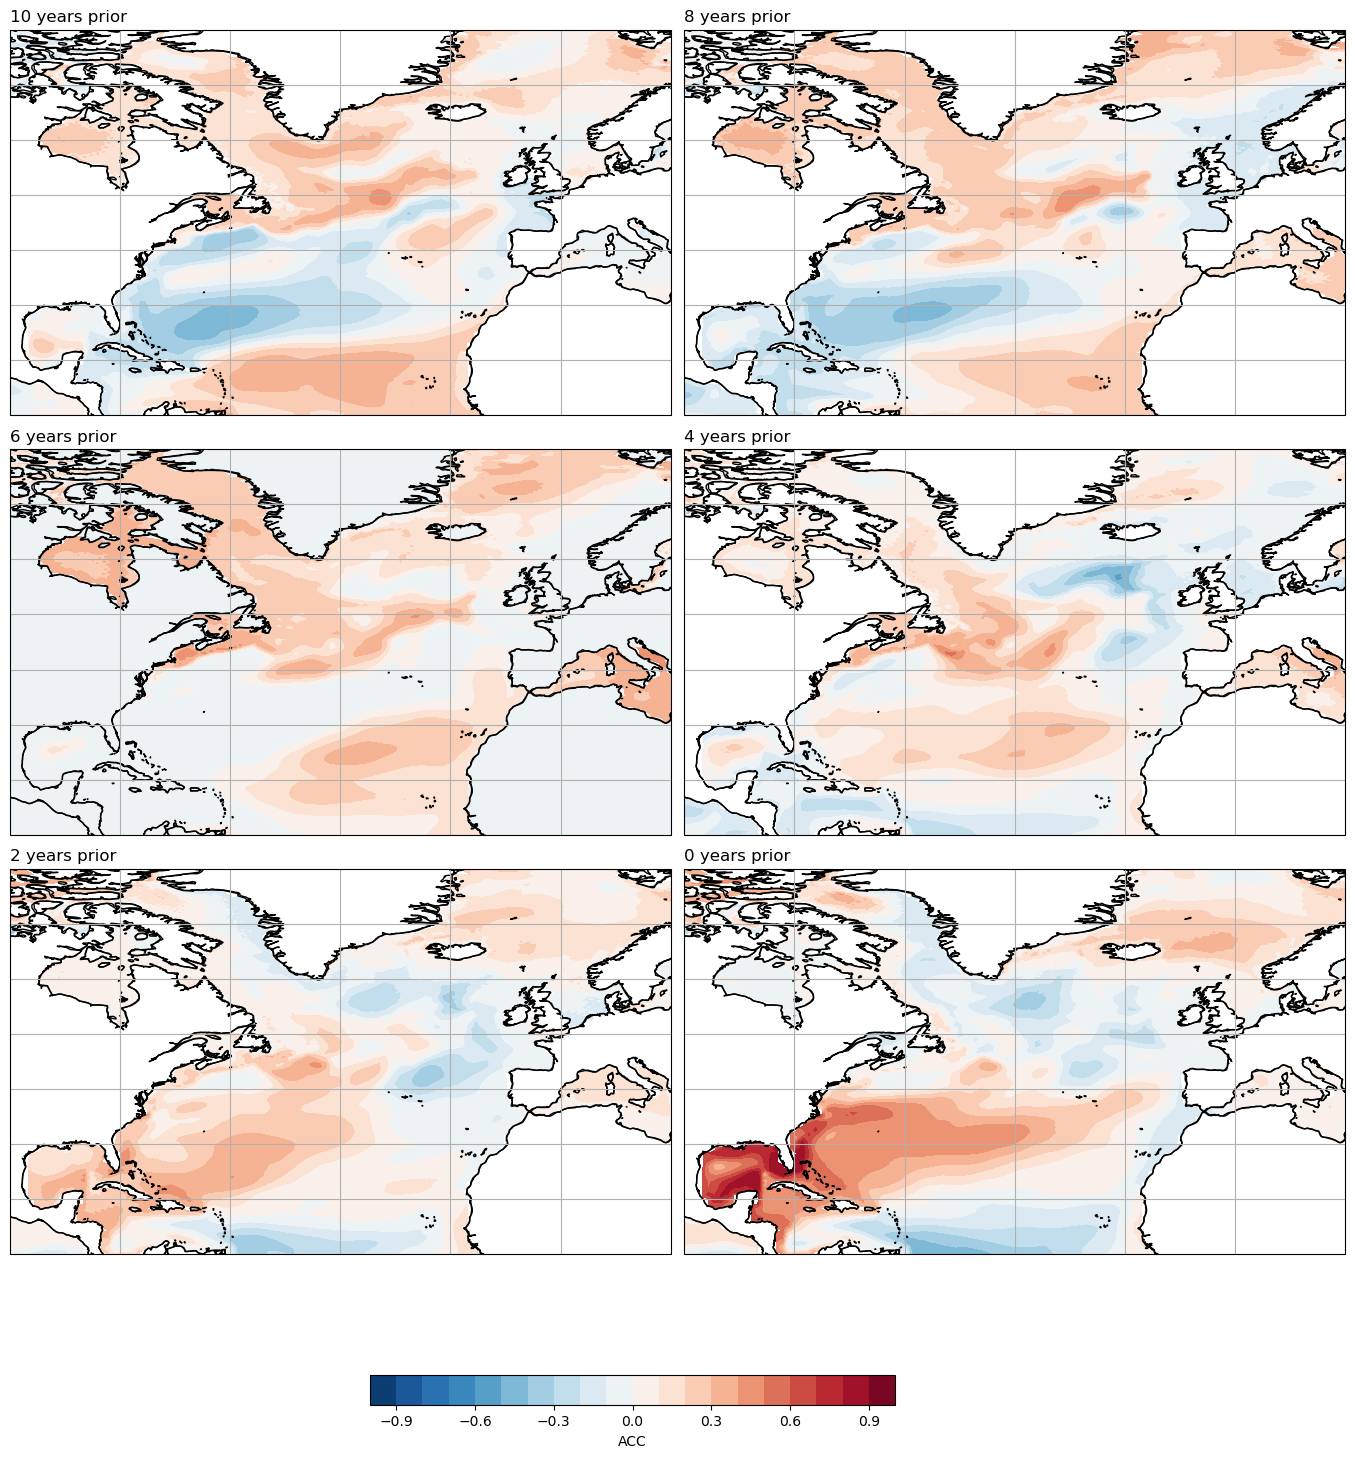

In [84]:
fontsize=12
colmap = copy.copy(plt.cm.RdBu_r)

# Create projection:
proj1 = ccrs.PlateCarree()
fig = plt.figure(figsize=(15, 15))
nrow = 3
ncol = 2
nplot = nrow*ncol

corrlevs = np.arange(0,21,1)*0.1 - 1

for i in range(nplot):
    ax = fig.add_subplot(nrow, ncol, i+1, projection=proj1)
    thislag = -10+i*2
    tmp = ssh_reg_egom.sel(lag=thislag).sel(stat='corr')
    lon, lat, dat = maps.adjust_pop_grid(lr_lon, lr_lat, tmp)
    cntr = ax.contourf(lon, lat, dat, levels=corrlevs, cmap=colmap, transform=ccrs.PlateCarree(), extend='neither')
    ax.coastlines(resolution='50m')
    ax.gridlines(draw_labels=False, dms=True, x_inline=False, y_inline=False)
    ax.set_title('{} years prior'.format(-thislag),fontsize=fontsize, loc='left')
    ax.coastlines()
    extent = [-100,20, 10, 80]
    ax.set_extent(extent,crs=ccrs.PlateCarree())

fig.tight_layout()
fig.subplots_adjust(bottom=0.15,right=0.9)
cbar_ax = fig.add_axes([0.25, 0.06, 0.35, 0.02])
fig.colorbar(cntr, cax=cbar_ax, orientation='horizontal',label='ACC')

#plt.savefig('HRFOSI_SSH_regress_FWC.png')